# MWE Shared on Discourse: 
# Solve 2D Poisson Using Ruge-Stueben and Smoothed-Aggregation AMG from AlgebraicMultigrid.jl  

<b> Goal: </b> compare performance of AMG methods implemented in AlgebraicMultigrid.jl as preconditioner for the CG-method with direct solution methods implemented in backslash. Comparison is performed in sequential (i.e. no parallel computation).    

<b> Findings: </b>: using AMG results in 
- important reduction of memory usage;
- grid independent convergence; 
- limited reduction of CPU time;
- these findings confirm similar finding by master student 

<b> Questions: </b> 
- is what follows executed too naively? Can faster coarsening be implemented? 
- is what follows confirmed elsewhere? 
- do more performant implementations exists (in PETSc.jl for instance)? 
- how can implementation ofc AMG be improved?  

## Import Packages  

In [1]:
using Kronecker 

using LinearAlgebra 
using SparseArrays 

using IterativeSolvers
using Preconditioners
using AlgebraicMultigrid

using BenchmarkTools
using Profile
using ProfileView

using Plots

## Section 1: Build Linear System Matrix and Right-Hand Side Vector 

In [2]:
function buildMat1D(N)
  Nm1 = N-1; Np1 = N+1 
  h = 1/N; h2 = h*h; 
  stencil = [-1/h2, 2/h2, -1/h2]; 
  #..Allocate row, column and value vector 
  I = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  J = zeros(Int64,3*Nm1) # allocate 1D array of Int64 
  vals = zeros(3*Nm1)
  #..Construct row, column and value vector 
  for i in 2:N
    offset = 3*(i-2)
    I[[offset+1, offset+2, offset+3]] = [i,i,i]
    J[[offset+1, offset+2, offset+3]] = [i-1,i,i+1]
    vals[[offset+1, offset+2, offset+3]] = stencil
  end 
  #..Build matrix for interior rows   
  A = sparse(I,J,vals,Np1,Np1)
  #..Build matrix for boundary rows
  A[1,1] = 1; A[end,end]=1; A[2,1] =0; A[end-1,end]=0; 
  return A 
end 

function buildMat2D(N)
    A1d = buildMat1D(N)
    A2d = KroneckerSum(A1d, A1d) # using lazy evaluation 
    return A2d 
end

function buildVec2D(N)
    Np1 = N+1
    n = Np1^2
    b2d = ones(n)
    return b2d  
end

buildVec2D (generic function with 1 method)

In [29]:
N =30
A2d = buildMat2D(N)
b = buildVec2D(N)
A = sparse(collect(A2d))
println(size(b))
println(size(A))

(961,)
(961, 961)


## Section 2: Solving Linear System using Backslask (as reference) 

In [30]:
@benchmark A\b

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  387.792 μs …   2.628 ms  ┊ GC (min … max): 0.00% … 36.59%
 Time  (median):     395.792 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   408.569 μs ± 139.802 μs  ┊ GC (mean ± σ):  1.10% ±  2.69%

    ▁▂ ▄██▆▅▄▂                                                   
  ▂▄███████████▇▅▅▄▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁ ▃
  388 μs           Histogram: frequency by time          441 μs <

 Memory estimate: 607.19 KiB, allocs estimate: 59.

## Section 3: Linear System Solve using Ruge-Stueben AMG as Preconditioner for CG 

In [31]:
#?AMGPreconditioner

In [6]:
p = AMGPreconditioner{RugeStuben}(A);
println(p)

AMGPreconditioner{RugeStuben, AlgebraicMultigrid.MultiLevel{AlgebraicMultigrid.Pinv{Float64}, GaussSeidel{SymmetricSweep}, GaussSeidel{SymmetricSweep}, SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}, SparseMatrixCSC{Float64, Int64}, AlgebraicMultigrid.MultiLevelWorkspace{Vector{Float64}, 1}}, AlgebraicMultigrid.V}(Multilevel Solver
-----------------
Operator Complexity: 1.611
Grid Complexity: 1.611
No. of Levels: 3
Coarse Solver: Pinv
Level     Unknowns     NonZeros
-----     --------     --------
    1           36          108 [62.07%]
    2           16           58 [33.33%]
    3            6            8 [ 4.60%]
, AlgebraicMultigrid.V())


In [45]:
#ml = ruge_stuben(A; max_levels=2)
#ml = ruge_stuben(A; strength = Classical(0.01))
ml = ruge_stuben(A,presmoother = GaussSeidel,postsmoother = GaussSeidel)
ml = ruge_stuben(A,presmoother = Jacobi,postsmoother = Jacobi)
#ml.final_A = Diagonal(ml.final_A)
p = aspreconditioner(ml)

LoadError: UndefVarError: Jacobi not defined

In [34]:
if (False) 
  ml.coarse_solver
  ml.final_A
end 
#typeof(ml)
#for (i, level) in enumerate(ml)
#    println(i)
#    printf "   %2d   %10d   %10d [%5.2f%%]\n" i size(p.level.A, 1) nnz(p.level.A) (100 * nnz(p.level.A) / total_nnz)
#end

LoadError: UndefVarError: False not defined

In [37]:
@benchmark cg(A, b, Pl=p, log=false)

BenchmarkTools.Trial: 9379 samples with 1 evaluation.
 Range (min … max):  523.000 μs …   6.994 ms  ┊ GC (min … max): 0.00% … 92.27%
 Time  (median):     527.333 μs               ┊ GC (median):    0.00%
 Time  (mean ± σ):   531.842 μs ± 104.569 μs  ┊ GC (mean ± σ):  0.35% ±  1.63%

   ▃▅▇▇██▇▆▆▆▅▄▃▂▂▂▁▁ ▁      ▁      ▁▁▁▁  ▁                     ▂
  █████████████████████████████████████████████▇▇█▇▇▅▆▅▆▆▇▆▅▅▆▆ █
  523 μs        Histogram: log(frequency) by time        562 μs <

 Memory estimate: 31.80 KiB, allocs estimate: 14.

  1	1.69e+01
  2	2.34e+00
  3	2.77e-01
  4	1.54e-02
  5	4.29e-04
  6	3.17e-05
  7	3.39e-06
  8	1.02e-07



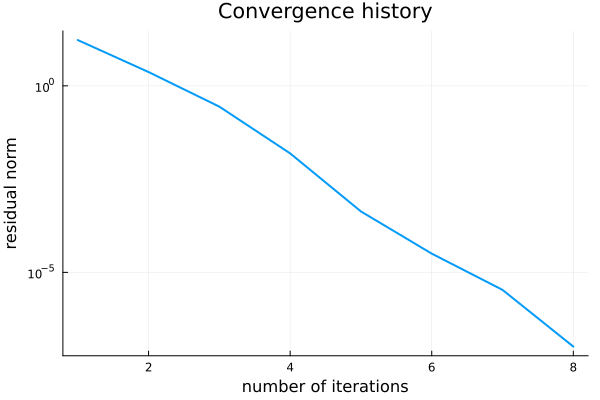

In [48]:
x, ch =cg(A, b, Pl=p, log=true, verbose=true);

p1=plot(ch[:resnorm], yaxis=:log,lw=2,legend=false)
xlabel!("number of iterations") 
ylabel!("residual norm")
title!("Convergence history")

plot(p1) 

## Section 4: Linear System Solve using Smoothed Aggregation AMG as Preconditioner for CG 

In [73]:
p = AMGPreconditioner{SmoothedAggregation}(A);
#p.ml.levels=2;
println(p)
println(p.ml.levels)

#for (i, level) in enumerate(p.ml.levels)
#    println(i)
#    lstr = lstr *
#    printf "   %2d   %10d   %10d [%5.2f%%]\n" i size(p.level.A, 1) nnz(p.level.A) (100 * nnz(p.level.A) / total_nnz)
#end


AMGPreconditioner{SmoothedAggregation, AlgebraicMultigrid.MultiLevel{AlgebraicMultigrid.Pinv{Float64}, GaussSeidel{SymmetricSweep}, GaussSeidel{SymmetricSweep}, SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}, AlgebraicMultigrid.MultiLevelWorkspace{Vector{Float64}, 1}}, AlgebraicMultigrid.V}(Multilevel Solver
-----------------
Operator Complexity: 1.348
Grid Complexity: 1.206
No. of Levels: 6
Coarse Solver: Pinv
Level     Unknowns     NonZeros
-----     --------     --------
    1        10201        49793 [74.19%]
    2         1806        15184 [22.62%]
    3          236         1860 [ 2.77%]
    4           40          248 [ 0.37%]
    5           11           25 [ 0.04%]
    6            5            5 [ 0.01%]
, AlgebraicMultigrid.V())


AlgebraicMultigrid.Level{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}}[AlgebraicMultigrid.Level{SparseMatrixCSC{Float64, Int64}, SparseMatrixCSC{Float64, Int64}, Adjoint{Float64, SparseMatrixCSC{Float64, Int64}}}(sparse([1, 2, 3, 2, 3, 4, 3, 4, 5, 4, 5, 6, 5, 6, 7, 6, 7, 8, 7, 8, 9, 8, 9, 10, 9, 10, 11, 10, 11, 12, 11, 12, 13, 12, 13, 14, 13, 14, 15, 14, 15, 16, 15, 16, 17, 16, 17, 18, 17, 18, 19, 18, 19, 20, 19, 20, 21, 20, 21, 22, 21, 22, 23, 22, 23, 24, 23, 24, 25, 24, 25, 26, 25, 26, 27, 26, 27, 28, 27, 28, 29, 28, 29, 30, 29, 30, 31, 30, 31, 32, 31, 32, 33, 32, 33, 34, 33, 34, 35, 34, 35, 36, 35, 36, 37, 36, 37, 38, 37, 38, 39, 38, 39, 40, 39, 40, 41, 40, 41, 42, 41, 42, 43, 42, 43, 44, 43, 44, 45, 44, 45, 46, 45, 46, 47, 46, 47, 48, 47, 48, 49, 48, 49, 50, 49, 50, 51, 50, 51, 52, 51, 52, 53, 52, 53, 54, 53, 54, 55, 54, 55, 56, 55, 56, 57, 56, 57, 58, 57, 58, 59, 58, 59, 60, 59, 60, 61, 60, 61, 62, 61, 62, 63, 

, 2396, 2496, 2295, 2395, 2396, 2397, 2497, 2296, 2396, 2397, 2398, 2498, 2297, 2397, 2398, 2399, 2499, 2298, 2398, 2399, 2400, 2500, 2299, 2399, 2400, 2401, 2501, 2300, 2400, 2401, 2402, 2502, 2301, 2401, 2402, 2403, 2503, 2302, 2402, 2403, 2404, 2504, 2303, 2403, 2404, 2405, 2505, 2304, 2404, 2405, 2406, 2506, 2305, 2405, 2406, 2407, 2507, 2306, 2406, 2407, 2408, 2508, 2307, 2407, 2408, 2409, 2509, 2308, 2408, 2409, 2410, 2510, 2309, 2409, 2410, 2411, 2511, 2310, 2410, 2411, 2412, 2512, 2311, 2411, 2412, 2413, 2513, 2312, 2412, 2413, 2414, 2514, 2313, 2413, 2414, 2415, 2515, 2314, 2414, 2415, 2416, 2516, 2315, 2415, 2416, 2417, 2517, 2316, 2416, 2417, 2418, 2518, 2317, 2417, 2418, 2419, 2519, 2318, 2418, 2419, 2420, 2520, 2319, 2419, 2420, 2421, 2521, 2320, 2420, 2421, 2422, 2522, 2321, 2421, 2422, 2423, 2523, 2322, 2422, 2423, 2524, 2323, 2424, 2525, 2324, 2425, 2526, 2325, 2426, 2427, 2527, 2326, 2426, 2427, 2428, 2528, 2327, 2427, 2428, 2429, 2529, 2328, 2428, 2429, 2430, 2530, 23

 2883, 2983, 2782, 2882, 2883, 2884, 2984, 2783, 2883, 2884, 2885, 2985, 2784, 2884, 2885, 2886, 2986, 2785, 2885, 2886, 2887, 2987, 2786, 2886, 2887, 2888, 2988, 2787, 2887, 2888, 2889, 2989, 2788, 2888, 2889, 2890, 2990, 2789, 2889, 2890, 2891, 2991, 2790, 2890, 2891, 2892, 2992, 2791, 2891, 2892, 2893, 2993, 2792, 2892, 2893, 2894, 2994, 2793, 2893, 2894, 2895, 2995, 2794, 2894, 2895, 2896, 2996, 2795, 2895, 2896, 2897, 2997, 2796, 2896, 2897, 2898, 2998, 2797, 2897, 2898, 2899, 2999, 2798, 2898, 2899, 2900, 3000, 2799, 2899, 2900, 2901, 3001, 2800, 2900, 2901, 2902, 3002, 2801, 2901, 2902, 2903, 3003, 2802, 2902, 2903, 2904, 3004, 2803, 2903, 2904, 2905, 3005, 2804, 2904, 2905, 2906, 3006, 2805, 2905, 2906, 2907, 3007, 2806, 2906, 2907, 2908, 3008, 2807, 2907, 2908, 2909, 3009, 2808, 2908, 2909, 2910, 3010, 2809, 2909, 2910, 2911, 3011, 2810, 2910, 2911, 2912, 3012, 2811, 2911, 2912, 2913, 3013, 2812, 2912, 2913, 2914, 3014, 2813, 2913, 2914, 2915, 3015, 2814, 2914, 2915, 2916, 301

 3470, 3269, 3369, 3370, 3371, 3471, 3270, 3370, 3371, 3372, 3472, 3271, 3371, 3372, 3373, 3473, 3272, 3372, 3373, 3374, 3474, 3273, 3373, 3374, 3375, 3475, 3274, 3374, 3375, 3376, 3476, 3275, 3375, 3376, 3377, 3477, 3276, 3376, 3377, 3378, 3478, 3277, 3377, 3378, 3379, 3479, 3278, 3378, 3379, 3380, 3480, 3279, 3379, 3380, 3381, 3481, 3280, 3380, 3381, 3382, 3482, 3281, 3381, 3382, 3383, 3483, 3282, 3382, 3383, 3384, 3484, 3283, 3383, 3384, 3385, 3485, 3284, 3384, 3385, 3386, 3486, 3285, 3385, 3386, 3387, 3487, 3286, 3386, 3387, 3388, 3488, 3287, 3387, 3388, 3389, 3489, 3288, 3388, 3389, 3390, 3490, 3289, 3389, 3390, 3391, 3491, 3290, 3390, 3391, 3392, 3492, 3291, 3391, 3392, 3393, 3493, 3292, 3392, 3393, 3394, 3494, 3293, 3393, 3394, 3395, 3495, 3294, 3394, 3395, 3396, 3496, 3295, 3395, 3396, 3397, 3497, 3296, 3396, 3397, 3398, 3498, 3297, 3397, 3398, 3399, 3499, 3298, 3398, 3399, 3400, 3500, 3299, 3399, 3400, 3401, 3501, 3300, 3400, 3401, 3402, 3502, 3301, 3401, 3402, 3403, 3503, 330

 3958, 3757, 3857, 3858, 3859, 3959, 3758, 3858, 3859, 3860, 3960, 3759, 3859, 3860, 3861, 3961, 3760, 3860, 3861, 3862, 3962, 3761, 3861, 3862, 3863, 3963, 3762, 3862, 3863, 3864, 3964, 3763, 3863, 3864, 3865, 3965, 3764, 3864, 3865, 3866, 3966, 3765, 3865, 3866, 3867, 3967, 3766, 3866, 3867, 3868, 3968, 3767, 3867, 3868, 3869, 3969, 3768, 3868, 3869, 3870, 3970, 3769, 3869, 3870, 3871, 3971, 3770, 3870, 3871, 3872, 3972, 3771, 3871, 3872, 3873, 3973, 3772, 3872, 3873, 3874, 3974, 3773, 3873, 3874, 3875, 3975, 3774, 3874, 3875, 3876, 3976, 3775, 3875, 3876, 3877, 3977, 3776, 3876, 3877, 3878, 3978, 3777, 3877, 3878, 3879, 3979, 3778, 3878, 3879, 3880, 3980, 3779, 3879, 3880, 3881, 3981, 3780, 3880, 3881, 3882, 3982, 3781, 3881, 3882, 3883, 3983, 3782, 3882, 3883, 3884, 3984, 3783, 3883, 3884, 3885, 3985, 3784, 3884, 3885, 3886, 3986, 3785, 3885, 3886, 3887, 3987, 3786, 3886, 3887, 3888, 3988, 3787, 3887, 3888, 3889, 3989, 3788, 3888, 3889, 3890, 3990, 3789, 3889, 3890, 3891, 3991, 379

 4341, 4342, 4442, 4241, 4341, 4342, 4443, 4242, 4343, 4444, 4243, 4344, 4445, 4244, 4345, 4346, 4446, 4245, 4345, 4346, 4347, 4447, 4246, 4346, 4347, 4348, 4448, 4247, 4347, 4348, 4349, 4449, 4248, 4348, 4349, 4350, 4450, 4249, 4349, 4350, 4351, 4451, 4250, 4350, 4351, 4352, 4452, 4251, 4351, 4352, 4353, 4453, 4252, 4352, 4353, 4354, 4454, 4253, 4353, 4354, 4355, 4455, 4254, 4354, 4355, 4356, 4456, 4255, 4355, 4356, 4357, 4457, 4256, 4356, 4357, 4358, 4458, 4257, 4357, 4358, 4359, 4459, 4258, 4358, 4359, 4360, 4460, 4259, 4359, 4360, 4361, 4461, 4260, 4360, 4361, 4362, 4462, 4261, 4361, 4362, 4363, 4463, 4262, 4362, 4363, 4364, 4464, 4263, 4363, 4364, 4365, 4465, 4264, 4364, 4365, 4366, 4466, 4265, 4365, 4366, 4367, 4467, 4266, 4366, 4367, 4368, 4468, 4267, 4367, 4368, 4369, 4469, 4268, 4368, 4369, 4370, 4470, 4269, 4369, 4370, 4371, 4471, 4270, 4370, 4371, 4372, 4472, 4271, 4371, 4372, 4373, 4473, 4272, 4372, 4373, 4374, 4474, 4273, 4373, 4374, 4375, 4475, 4274, 4374, 4375, 4376, 447

 4815, 4816, 4916, 4715, 4815, 4816, 4817, 4917, 4716, 4816, 4817, 4818, 4918, 4717, 4817, 4818, 4819, 4919, 4718, 4818, 4819, 4820, 4920, 4719, 4819, 4820, 4821, 4921, 4720, 4820, 4821, 4822, 4922, 4721, 4821, 4822, 4823, 4923, 4722, 4822, 4823, 4824, 4924, 4723, 4823, 4824, 4825, 4925, 4724, 4824, 4825, 4826, 4926, 4725, 4825, 4826, 4827, 4927, 4726, 4826, 4827, 4828, 4928, 4727, 4827, 4828, 4829, 4929, 4728, 4828, 4829, 4830, 4930, 4729, 4829, 4830, 4831, 4931, 4730, 4830, 4831, 4832, 4932, 4731, 4831, 4832, 4833, 4933, 4732, 4832, 4833, 4834, 4934, 4733, 4833, 4834, 4835, 4935, 4734, 4834, 4835, 4836, 4936, 4735, 4835, 4836, 4837, 4937, 4736, 4836, 4837, 4838, 4938, 4737, 4837, 4838, 4839, 4939, 4738, 4838, 4839, 4840, 4940, 4739, 4839, 4840, 4841, 4941, 4740, 4840, 4841, 4842, 4942, 4741, 4841, 4842, 4843, 4943, 4742, 4842, 4843, 4844, 4944, 4743, 4843, 4844, 4845, 4945, 4744, 4844, 4845, 4846, 4946, 4745, 4845, 4846, 4847, 4947, 4746, 4846, 4847, 4948, 4747, 4848, 4949, 4748, 484

, 5300, 5301, 5401, 5200, 5300, 5301, 5302, 5402, 5201, 5301, 5302, 5303, 5403, 5202, 5302, 5303, 5304, 5404, 5203, 5303, 5304, 5305, 5405, 5204, 5304, 5305, 5306, 5406, 5205, 5305, 5306, 5307, 5407, 5206, 5306, 5307, 5308, 5408, 5207, 5307, 5308, 5309, 5409, 5208, 5308, 5309, 5310, 5410, 5209, 5309, 5310, 5311, 5411, 5210, 5310, 5311, 5312, 5412, 5211, 5311, 5312, 5313, 5413, 5212, 5312, 5313, 5314, 5414, 5213, 5313, 5314, 5315, 5415, 5214, 5314, 5315, 5316, 5416, 5215, 5315, 5316, 5317, 5417, 5216, 5316, 5317, 5318, 5418, 5217, 5317, 5318, 5319, 5419, 5218, 5318, 5319, 5320, 5420, 5219, 5319, 5320, 5321, 5421, 5220, 5320, 5321, 5322, 5422, 5221, 5321, 5322, 5323, 5423, 5222, 5322, 5323, 5324, 5424, 5223, 5323, 5324, 5325, 5425, 5224, 5324, 5325, 5326, 5426, 5225, 5325, 5326, 5327, 5427, 5226, 5326, 5327, 5328, 5428, 5227, 5327, 5328, 5329, 5429, 5228, 5328, 5329, 5330, 5430, 5229, 5329, 5330, 5331, 5431, 5230, 5330, 5331, 5332, 5432, 5231, 5331, 5332, 5333, 5433, 5232, 5332, 5333, 53

 5789, 5790, 5791, 5891, 5690, 5790, 5791, 5792, 5892, 5691, 5791, 5792, 5793, 5893, 5692, 5792, 5793, 5794, 5894, 5693, 5793, 5794, 5795, 5895, 5694, 5794, 5795, 5796, 5896, 5695, 5795, 5796, 5797, 5897, 5696, 5796, 5797, 5798, 5898, 5697, 5797, 5798, 5799, 5899, 5698, 5798, 5799, 5800, 5900, 5699, 5799, 5800, 5801, 5901, 5700, 5800, 5801, 5802, 5902, 5701, 5801, 5802, 5803, 5903, 5702, 5802, 5803, 5804, 5904, 5703, 5803, 5804, 5805, 5905, 5704, 5804, 5805, 5806, 5906, 5705, 5805, 5806, 5807, 5907, 5706, 5806, 5807, 5808, 5908, 5707, 5807, 5808, 5809, 5909, 5708, 5808, 5809, 5810, 5910, 5709, 5809, 5810, 5811, 5911, 5710, 5810, 5811, 5812, 5912, 5711, 5811, 5812, 5813, 5913, 5712, 5812, 5813, 5814, 5914, 5713, 5813, 5814, 5815, 5915, 5714, 5814, 5815, 5816, 5916, 5715, 5815, 5816, 5817, 5917, 5716, 5816, 5817, 5818, 5918, 5717, 5817, 5818, 5819, 5919, 5718, 5818, 5819, 5820, 5920, 5719, 5819, 5820, 5821, 5921, 5720, 5820, 5821, 5822, 5922, 5721, 5821, 5822, 5823, 5923, 5722, 5822, 582

 6370, 6169, 6269, 6270, 6271, 6371, 6170, 6270, 6271, 6272, 6372, 6171, 6271, 6272, 6273, 6373, 6172, 6272, 6273, 6274, 6374, 6173, 6273, 6274, 6275, 6375, 6174, 6274, 6275, 6276, 6376, 6175, 6275, 6276, 6277, 6377, 6176, 6276, 6277, 6278, 6378, 6177, 6277, 6278, 6279, 6379, 6178, 6278, 6279, 6280, 6380, 6179, 6279, 6280, 6281, 6381, 6180, 6280, 6281, 6282, 6382, 6181, 6281, 6282, 6283, 6383, 6182, 6282, 6283, 6284, 6384, 6183, 6283, 6284, 6285, 6385, 6184, 6284, 6285, 6286, 6386, 6185, 6285, 6286, 6287, 6387, 6186, 6286, 6287, 6288, 6388, 6187, 6287, 6288, 6289, 6389, 6188, 6288, 6289, 6290, 6390, 6189, 6289, 6290, 6291, 6391, 6190, 6290, 6291, 6292, 6392, 6191, 6291, 6292, 6293, 6393, 6192, 6292, 6293, 6294, 6394, 6193, 6293, 6294, 6295, 6395, 6194, 6294, 6295, 6296, 6396, 6195, 6295, 6296, 6297, 6397, 6196, 6296, 6297, 6298, 6398, 6197, 6297, 6298, 6299, 6399, 6198, 6298, 6299, 6300, 6400, 6199, 6299, 6300, 6301, 6401, 6200, 6300, 6301, 6302, 6402, 6201, 6301, 6302, 6303, 6403, 620

 6818, 6617, 6717, 6718, 6719, 6819, 6618, 6718, 6719, 6720, 6820, 6619, 6719, 6720, 6721, 6821, 6620, 6720, 6721, 6722, 6822, 6621, 6721, 6722, 6723, 6823, 6622, 6722, 6723, 6724, 6824, 6623, 6723, 6724, 6725, 6825, 6624, 6724, 6725, 6726, 6826, 6625, 6725, 6726, 6727, 6827, 6626, 6726, 6727, 6728, 6828, 6627, 6727, 6728, 6729, 6829, 6628, 6728, 6729, 6730, 6830, 6629, 6729, 6730, 6731, 6831, 6630, 6730, 6731, 6732, 6832, 6631, 6731, 6732, 6733, 6833, 6632, 6732, 6733, 6734, 6834, 6633, 6733, 6734, 6735, 6835, 6634, 6734, 6735, 6736, 6836, 6635, 6735, 6736, 6737, 6837, 6636, 6736, 6737, 6738, 6838, 6637, 6737, 6738, 6739, 6839, 6638, 6738, 6739, 6740, 6840, 6639, 6739, 6740, 6741, 6841, 6640, 6740, 6741, 6742, 6842, 6641, 6741, 6742, 6743, 6843, 6642, 6742, 6743, 6744, 6844, 6643, 6743, 6744, 6745, 6845, 6644, 6744, 6745, 6746, 6846, 6645, 6745, 6746, 6747, 6847, 6646, 6746, 6747, 6748, 6848, 6647, 6747, 6748, 6749, 6849, 6648, 6748, 6749, 6750, 6850, 6649, 6749, 6750, 6751, 6851, 665

, 7170, 7270, 7069, 7169, 7170, 7271, 7070, 7171, 7272, 7071, 7172, 7273, 7072, 7173, 7174, 7274, 7073, 7173, 7174, 7175, 7275, 7074, 7174, 7175, 7176, 7276, 7075, 7175, 7176, 7177, 7277, 7076, 7176, 7177, 7178, 7278, 7077, 7177, 7178, 7179, 7279, 7078, 7178, 7179, 7180, 7280, 7079, 7179, 7180, 7181, 7281, 7080, 7180, 7181, 7182, 7282, 7081, 7181, 7182, 7183, 7283, 7082, 7182, 7183, 7184, 7284, 7083, 7183, 7184, 7185, 7285, 7084, 7184, 7185, 7186, 7286, 7085, 7185, 7186, 7187, 7287, 7086, 7186, 7187, 7188, 7288, 7087, 7187, 7188, 7189, 7289, 7088, 7188, 7189, 7190, 7290, 7089, 7189, 7190, 7191, 7291, 7090, 7190, 7191, 7192, 7292, 7091, 7191, 7192, 7193, 7293, 7092, 7192, 7193, 7194, 7294, 7093, 7193, 7194, 7195, 7295, 7094, 7194, 7195, 7196, 7296, 7095, 7195, 7196, 7197, 7297, 7096, 7196, 7197, 7198, 7298, 7097, 7197, 7198, 7199, 7299, 7098, 7198, 7199, 7200, 7300, 7099, 7199, 7200, 7201, 7301, 7100, 7200, 7201, 7202, 7302, 7101, 7201, 7202, 7203, 7303, 7102, 7202, 7203, 7204, 7304, 71

, 7725, 7524, 7624, 7625, 7626, 7726, 7525, 7625, 7626, 7627, 7727, 7526, 7626, 7627, 7628, 7728, 7527, 7627, 7628, 7629, 7729, 7528, 7628, 7629, 7630, 7730, 7529, 7629, 7630, 7631, 7731, 7530, 7630, 7631, 7632, 7732, 7531, 7631, 7632, 7633, 7733, 7532, 7632, 7633, 7634, 7734, 7533, 7633, 7634, 7635, 7735, 7534, 7634, 7635, 7636, 7736, 7535, 7635, 7636, 7637, 7737, 7536, 7636, 7637, 7638, 7738, 7537, 7637, 7638, 7639, 7739, 7538, 7638, 7639, 7640, 7740, 7539, 7639, 7640, 7641, 7741, 7540, 7640, 7641, 7642, 7742, 7541, 7641, 7642, 7643, 7743, 7542, 7642, 7643, 7644, 7744, 7543, 7643, 7644, 7645, 7745, 7544, 7644, 7645, 7646, 7746, 7545, 7645, 7646, 7647, 7747, 7546, 7646, 7647, 7648, 7748, 7547, 7647, 7648, 7649, 7749, 7548, 7648, 7649, 7650, 7750, 7549, 7649, 7650, 7651, 7751, 7550, 7650, 7651, 7652, 7752, 7551, 7651, 7652, 7653, 7753, 7552, 7652, 7653, 7654, 7754, 7553, 7653, 7654, 7655, 7755, 7554, 7654, 7655, 7656, 7756, 7555, 7655, 7656, 7657, 7757, 7556, 7656, 7657, 7658, 7758, 75

, 8092, 8093, 8094, 8194, 7993, 8093, 8094, 8095, 8195, 7994, 8094, 8095, 8096, 8196, 7995, 8095, 8096, 8097, 8197, 7996, 8096, 8097, 8098, 8198, 7997, 8097, 8098, 8099, 8199, 7998, 8098, 8099, 8100, 8200, 7999, 8099, 8100, 8101, 8201, 8000, 8100, 8101, 8102, 8202, 8001, 8101, 8102, 8103, 8203, 8002, 8102, 8103, 8104, 8204, 8003, 8103, 8104, 8105, 8205, 8004, 8104, 8105, 8106, 8206, 8005, 8105, 8106, 8107, 8207, 8006, 8106, 8107, 8108, 8208, 8007, 8107, 8108, 8109, 8209, 8008, 8108, 8109, 8110, 8210, 8009, 8109, 8110, 8111, 8211, 8010, 8110, 8111, 8112, 8212, 8011, 8111, 8112, 8113, 8213, 8012, 8112, 8113, 8114, 8214, 8013, 8113, 8114, 8115, 8215, 8014, 8114, 8115, 8116, 8216, 8015, 8115, 8116, 8117, 8217, 8016, 8116, 8117, 8118, 8218, 8017, 8117, 8118, 8119, 8219, 8018, 8118, 8119, 8120, 8220, 8019, 8119, 8120, 8121, 8221, 8020, 8120, 8121, 8122, 8222, 8021, 8121, 8122, 8123, 8223, 8022, 8122, 8123, 8124, 8224, 8023, 8123, 8124, 8125, 8225, 8024, 8124, 8125, 8126, 8226, 8025, 8125, 81

 8650, 8449, 8549, 8550, 8551, 8651, 8450, 8550, 8551, 8552, 8652, 8451, 8551, 8552, 8553, 8653, 8452, 8552, 8553, 8554, 8654, 8453, 8553, 8554, 8555, 8655, 8454, 8554, 8555, 8556, 8656, 8455, 8555, 8556, 8557, 8657, 8456, 8556, 8557, 8558, 8658, 8457, 8557, 8558, 8559, 8659, 8458, 8558, 8559, 8560, 8660, 8459, 8559, 8560, 8561, 8661, 8460, 8560, 8561, 8562, 8662, 8461, 8561, 8562, 8563, 8663, 8462, 8562, 8563, 8564, 8664, 8463, 8563, 8564, 8565, 8665, 8464, 8564, 8565, 8566, 8666, 8465, 8565, 8566, 8567, 8667, 8466, 8566, 8567, 8568, 8668, 8467, 8567, 8568, 8569, 8669, 8468, 8568, 8569, 8570, 8670, 8469, 8569, 8570, 8571, 8671, 8470, 8570, 8571, 8572, 8672, 8471, 8571, 8572, 8573, 8673, 8472, 8572, 8573, 8574, 8674, 8473, 8573, 8574, 8575, 8675, 8474, 8574, 8575, 8576, 8676, 8475, 8575, 8576, 8577, 8677, 8476, 8576, 8577, 8578, 8678, 8477, 8577, 8578, 8579, 8679, 8478, 8578, 8579, 8580, 8680, 8479, 8579, 8580, 8581, 8681, 8480, 8580, 8581, 8582, 8682, 8481, 8581, 8582, 8583, 8683, 848

 9116, 8915, 9015, 9016, 9017, 9117, 8916, 9016, 9017, 9018, 9118, 8917, 9017, 9018, 9019, 9119, 8918, 9018, 9019, 9020, 9120, 8919, 9019, 9020, 9021, 9121, 8920, 9020, 9021, 9022, 9122, 8921, 9021, 9022, 9023, 9123, 8922, 9022, 9023, 9024, 9124, 8923, 9023, 9024, 9025, 9125, 8924, 9024, 9025, 9026, 9126, 8925, 9025, 9026, 9027, 9127, 8926, 9026, 9027, 9028, 9128, 8927, 9027, 9028, 9029, 9129, 8928, 9028, 9029, 9030, 9130, 8929, 9029, 9030, 9031, 9131, 8930, 9030, 9031, 9032, 9132, 8931, 9031, 9032, 9033, 9133, 8932, 9032, 9033, 9034, 9134, 8933, 9033, 9034, 9035, 9135, 8934, 9034, 9035, 9036, 9136, 8935, 9035, 9036, 9037, 9137, 8936, 9036, 9037, 9038, 9138, 8937, 9037, 9038, 9039, 9139, 8938, 9038, 9039, 9040, 9140, 8939, 9039, 9040, 9041, 9141, 8940, 9040, 9041, 9042, 9142, 8941, 9041, 9042, 9043, 9143, 8942, 9042, 9043, 9044, 9144, 8943, 9043, 9044, 9045, 9145, 8944, 9044, 9045, 9046, 9146, 8945, 9045, 9046, 9047, 9147, 8946, 9046, 9047, 9048, 9148, 8947, 9047, 9048, 9049, 9149, 894

 9495, 9596, 9395, 9496, 9497, 9597, 9396, 9496, 9497, 9498, 9598, 9397, 9497, 9498, 9499, 9599, 9398, 9498, 9499, 9500, 9600, 9399, 9499, 9500, 9501, 9601, 9400, 9500, 9501, 9502, 9602, 9401, 9501, 9502, 9503, 9603, 9402, 9502, 9503, 9504, 9604, 9403, 9503, 9504, 9505, 9605, 9404, 9504, 9505, 9506, 9606, 9405, 9505, 9506, 9507, 9607, 9406, 9506, 9507, 9508, 9608, 9407, 9507, 9508, 9509, 9609, 9408, 9508, 9509, 9510, 9610, 9409, 9509, 9510, 9511, 9611, 9410, 9510, 9511, 9512, 9612, 9411, 9511, 9512, 9513, 9613, 9412, 9512, 9513, 9514, 9614, 9413, 9513, 9514, 9515, 9615, 9414, 9514, 9515, 9516, 9616, 9415, 9515, 9516, 9517, 9617, 9416, 9516, 9517, 9518, 9618, 9417, 9517, 9518, 9519, 9619, 9418, 9518, 9519, 9520, 9620, 9419, 9519, 9520, 9521, 9621, 9420, 9520, 9521, 9522, 9622, 9421, 9521, 9522, 9523, 9623, 9422, 9522, 9523, 9524, 9624, 9423, 9523, 9524, 9525, 9625, 9424, 9524, 9525, 9526, 9626, 9425, 9525, 9526, 9527, 9627, 9426, 9526, 9527, 9528, 9628, 9427, 9527, 9528, 9529, 9629, 942

, 10059, 9858, 9958, 9959, 9960, 10060, 9859, 9959, 9960, 9961, 10061, 9860, 9960, 9961, 9962, 10062, 9861, 9961, 9962, 9963, 10063, 9862, 9962, 9963, 9964, 10064, 9863, 9963, 9964, 9965, 10065, 9864, 9964, 9965, 9966, 10066, 9865, 9965, 9966, 9967, 10067, 9866, 9966, 9967, 9968, 10068, 9867, 9967, 9968, 9969, 10069, 9868, 9968, 9969, 9970, 10070, 9869, 9969, 9970, 9971, 10071, 9870, 9970, 9971, 9972, 10072, 9871, 9971, 9972, 9973, 10073, 9872, 9972, 9973, 9974, 10074, 9873, 9973, 9974, 9975, 10075, 9874, 9974, 9975, 9976, 10076, 9875, 9975, 9976, 9977, 10077, 9876, 9976, 9977, 9978, 10078, 9877, 9977, 9978, 9979, 10079, 9878, 9978, 9979, 9980, 10080, 9879, 9979, 9980, 9981, 10081, 9880, 9980, 9981, 9982, 10082, 9881, 9981, 9982, 9983, 10083, 9882, 9982, 9983, 9984, 10084, 9883, 9983, 9984, 9985, 10085, 9884, 9984, 9985, 9986, 10086, 9885, 9985, 9986, 9987, 10087, 9886, 9986, 9987, 9988, 10088, 9887, 9987, 9988, 9989, 10089, 9888, 9988, 9989, 9990, 10090, 9889, 9989, 9990, 9991, 10091,

 406, 406, 406, 406, 407, 407, 407, 407, 407, 408, 408, 408, 408, 408, 409, 409, 409, 409, 409, 410, 410, 410, 410, 410, 411, 411, 411, 411, 411, 412, 412, 412, 412, 412, 413, 413, 413, 413, 413, 414, 414, 414, 414, 414, 415, 415, 415, 415, 415, 416, 416, 416, 416, 416, 417, 417, 417, 417, 417, 418, 418, 418, 418, 418, 419, 419, 419, 419, 419, 420, 420, 420, 420, 420, 421, 421, 421, 421, 421, 422, 422, 422, 422, 422, 423, 423, 423, 423, 423, 424, 424, 424, 424, 424, 425, 425, 425, 425, 425, 426, 426, 426, 426, 426, 427, 427, 427, 427, 427, 428, 428, 428, 428, 428, 429, 429, 429, 429, 429, 430, 430, 430, 430, 430, 431, 431, 431, 431, 431, 432, 432, 432, 432, 432, 433, 433, 433, 433, 433, 434, 434, 434, 434, 434, 435, 435, 435, 435, 435, 436, 436, 436, 436, 436, 437, 437, 437, 437, 437, 438, 438, 438, 438, 438, 439, 439, 439, 439, 439, 440, 440, 440, 440, 440, 441, 441, 441, 441, 441, 442, 442, 442, 442, 442, 443, 443, 443, 443, 443, 444, 444, 444, 444, 444, 445, 445, 445, 445, 445, 446,

 886, 886, 886, 886, 887, 887, 887, 887, 887, 888, 888, 888, 888, 888, 889, 889, 889, 889, 889, 890, 890, 890, 890, 890, 891, 891, 891, 891, 891, 892, 892, 892, 892, 892, 893, 893, 893, 893, 893, 894, 894, 894, 894, 894, 895, 895, 895, 895, 895, 896, 896, 896, 896, 896, 897, 897, 897, 897, 897, 898, 898, 898, 898, 898, 899, 899, 899, 899, 899, 900, 900, 900, 900, 900, 901, 901, 901, 901, 901, 902, 902, 902, 902, 902, 903, 903, 903, 903, 903, 904, 904, 904, 904, 904, 905, 905, 905, 905, 905, 906, 906, 906, 906, 906, 907, 907, 907, 907, 907, 908, 908, 908, 908, 909, 909, 909, 910, 910, 910, 911, 911, 911, 911, 912, 912, 912, 912, 912, 913, 913, 913, 913, 913, 914, 914, 914, 914, 914, 915, 915, 915, 915, 915, 916, 916, 916, 916, 916, 917, 917, 917, 917, 917, 918, 918, 918, 918, 918, 919, 919, 919, 919, 919, 920, 920, 920, 920, 920, 921, 921, 921, 921, 921, 922, 922, 922, 922, 922, 923, 923, 923, 923, 923, 924, 924, 924, 924, 924, 925, 925, 925, 925, 925, 926, 926, 926, 926, 926, 927, 927,

, 1274, 1275, 1275, 1275, 1275, 1275, 1276, 1276, 1276, 1276, 1276, 1277, 1277, 1277, 1277, 1277, 1278, 1278, 1278, 1278, 1278, 1279, 1279, 1279, 1279, 1279, 1280, 1280, 1280, 1280, 1280, 1281, 1281, 1281, 1281, 1281, 1282, 1282, 1282, 1282, 1282, 1283, 1283, 1283, 1283, 1283, 1284, 1284, 1284, 1284, 1284, 1285, 1285, 1285, 1285, 1285, 1286, 1286, 1286, 1286, 1286, 1287, 1287, 1287, 1287, 1287, 1288, 1288, 1288, 1288, 1288, 1289, 1289, 1289, 1289, 1289, 1290, 1290, 1290, 1290, 1290, 1291, 1291, 1291, 1291, 1291, 1292, 1292, 1292, 1292, 1292, 1293, 1293, 1293, 1293, 1293, 1294, 1294, 1294, 1294, 1294, 1295, 1295, 1295, 1295, 1295, 1296, 1296, 1296, 1296, 1296, 1297, 1297, 1297, 1297, 1297, 1298, 1298, 1298, 1298, 1298, 1299, 1299, 1299, 1299, 1299, 1300, 1300, 1300, 1300, 1300, 1301, 1301, 1301, 1301, 1301, 1302, 1302, 1302, 1302, 1302, 1303, 1303, 1303, 1303, 1303, 1304, 1304, 1304, 1304, 1304, 1305, 1305, 1305, 1305, 1305, 1306, 1306, 1306, 1306, 1306, 1307, 1307, 1307, 1307, 1307, 13

, 1730, 1731, 1731, 1731, 1731, 1731, 1732, 1732, 1732, 1732, 1732, 1733, 1733, 1733, 1733, 1733, 1734, 1734, 1734, 1734, 1734, 1735, 1735, 1735, 1735, 1735, 1736, 1736, 1736, 1736, 1736, 1737, 1737, 1737, 1737, 1737, 1738, 1738, 1738, 1738, 1738, 1739, 1739, 1739, 1739, 1739, 1740, 1740, 1740, 1740, 1740, 1741, 1741, 1741, 1741, 1741, 1742, 1742, 1742, 1742, 1742, 1743, 1743, 1743, 1743, 1743, 1744, 1744, 1744, 1744, 1744, 1745, 1745, 1745, 1745, 1745, 1746, 1746, 1746, 1746, 1746, 1747, 1747, 1747, 1747, 1747, 1748, 1748, 1748, 1748, 1748, 1749, 1749, 1749, 1749, 1749, 1750, 1750, 1750, 1750, 1750, 1751, 1751, 1751, 1751, 1751, 1752, 1752, 1752, 1752, 1752, 1753, 1753, 1753, 1753, 1753, 1754, 1754, 1754, 1754, 1754, 1755, 1755, 1755, 1755, 1755, 1756, 1756, 1756, 1756, 1756, 1757, 1757, 1757, 1757, 1757, 1758, 1758, 1758, 1758, 1758, 1759, 1759, 1759, 1759, 1759, 1760, 1760, 1760, 1760, 1760, 1761, 1761, 1761, 1761, 1761, 1762, 1762, 1762, 1762, 1762, 1763, 1763, 1763, 1763, 1763, 17

 2197, 2197, 2197, 2198, 2198, 2198, 2198, 2198, 2199, 2199, 2199, 2199, 2199, 2200, 2200, 2200, 2200, 2200, 2201, 2201, 2201, 2201, 2201, 2202, 2202, 2202, 2202, 2202, 2203, 2203, 2203, 2203, 2203, 2204, 2204, 2204, 2204, 2204, 2205, 2205, 2205, 2205, 2205, 2206, 2206, 2206, 2206, 2206, 2207, 2207, 2207, 2207, 2207, 2208, 2208, 2208, 2208, 2208, 2209, 2209, 2209, 2209, 2209, 2210, 2210, 2210, 2210, 2210, 2211, 2211, 2211, 2211, 2211, 2212, 2212, 2212, 2212, 2212, 2213, 2213, 2213, 2213, 2213, 2214, 2214, 2214, 2214, 2214, 2215, 2215, 2215, 2215, 2215, 2216, 2216, 2216, 2216, 2216, 2217, 2217, 2217, 2217, 2217, 2218, 2218, 2218, 2218, 2218, 2219, 2219, 2219, 2219, 2219, 2220, 2220, 2220, 2220, 2220, 2221, 2221, 2221, 2221, 2222, 2222, 2222, 2223, 2223, 2223, 2224, 2224, 2224, 2224, 2225, 2225, 2225, 2225, 2225, 2226, 2226, 2226, 2226, 2226, 2227, 2227, 2227, 2227, 2227, 2228, 2228, 2228, 2228, 2228, 2229, 2229, 2229, 2229, 2229, 2230, 2230, 2230, 2230, 2230, 2231, 2231, 2231, 2231, 223

, 2675, 2675, 2676, 2676, 2676, 2676, 2676, 2677, 2677, 2677, 2677, 2677, 2678, 2678, 2678, 2678, 2678, 2679, 2679, 2679, 2679, 2679, 2680, 2680, 2680, 2680, 2680, 2681, 2681, 2681, 2681, 2681, 2682, 2682, 2682, 2682, 2682, 2683, 2683, 2683, 2683, 2683, 2684, 2684, 2684, 2684, 2684, 2685, 2685, 2685, 2685, 2685, 2686, 2686, 2686, 2686, 2686, 2687, 2687, 2687, 2687, 2687, 2688, 2688, 2688, 2688, 2688, 2689, 2689, 2689, 2689, 2689, 2690, 2690, 2690, 2690, 2690, 2691, 2691, 2691, 2691, 2691, 2692, 2692, 2692, 2692, 2692, 2693, 2693, 2693, 2693, 2693, 2694, 2694, 2694, 2694, 2694, 2695, 2695, 2695, 2695, 2695, 2696, 2696, 2696, 2696, 2696, 2697, 2697, 2697, 2697, 2697, 2698, 2698, 2698, 2698, 2698, 2699, 2699, 2699, 2699, 2699, 2700, 2700, 2700, 2700, 2700, 2701, 2701, 2701, 2701, 2701, 2702, 2702, 2702, 2702, 2702, 2703, 2703, 2703, 2703, 2703, 2704, 2704, 2704, 2704, 2704, 2705, 2705, 2705, 2705, 2705, 2706, 2706, 2706, 2706, 2706, 2707, 2707, 2707, 2707, 2707, 2708, 2708, 2708, 2708, 27

 3141, 3141, 3141, 3142, 3142, 3142, 3142, 3142, 3143, 3143, 3143, 3143, 3143, 3144, 3144, 3144, 3144, 3144, 3145, 3145, 3145, 3145, 3145, 3146, 3146, 3146, 3146, 3146, 3147, 3147, 3147, 3147, 3147, 3148, 3148, 3148, 3148, 3148, 3149, 3149, 3149, 3149, 3149, 3150, 3150, 3150, 3150, 3150, 3151, 3151, 3151, 3151, 3151, 3152, 3152, 3152, 3152, 3152, 3153, 3153, 3153, 3153, 3153, 3154, 3154, 3154, 3154, 3154, 3155, 3155, 3155, 3155, 3155, 3156, 3156, 3156, 3156, 3156, 3157, 3157, 3157, 3157, 3157, 3158, 3158, 3158, 3158, 3158, 3159, 3159, 3159, 3159, 3159, 3160, 3160, 3160, 3160, 3160, 3161, 3161, 3161, 3161, 3161, 3162, 3162, 3162, 3162, 3162, 3163, 3163, 3163, 3163, 3163, 3164, 3164, 3164, 3164, 3164, 3165, 3165, 3165, 3165, 3165, 3166, 3166, 3166, 3166, 3166, 3167, 3167, 3167, 3167, 3167, 3168, 3168, 3168, 3168, 3168, 3169, 3169, 3169, 3169, 3169, 3170, 3170, 3170, 3170, 3170, 3171, 3171, 3171, 3171, 3171, 3172, 3172, 3172, 3172, 3172, 3173, 3173, 3173, 3173, 3173, 3174, 3174, 3174, 317

, 3609, 3609, 3610, 3610, 3610, 3610, 3610, 3611, 3611, 3611, 3611, 3611, 3612, 3612, 3612, 3612, 3612, 3613, 3613, 3613, 3613, 3613, 3614, 3614, 3614, 3614, 3614, 3615, 3615, 3615, 3615, 3615, 3616, 3616, 3616, 3616, 3616, 3617, 3617, 3617, 3617, 3617, 3618, 3618, 3618, 3618, 3618, 3619, 3619, 3619, 3619, 3619, 3620, 3620, 3620, 3620, 3620, 3621, 3621, 3621, 3621, 3621, 3622, 3622, 3622, 3622, 3622, 3623, 3623, 3623, 3623, 3623, 3624, 3624, 3624, 3624, 3624, 3625, 3625, 3625, 3625, 3625, 3626, 3626, 3626, 3626, 3626, 3627, 3627, 3627, 3627, 3627, 3628, 3628, 3628, 3628, 3628, 3629, 3629, 3629, 3629, 3629, 3630, 3630, 3630, 3630, 3630, 3631, 3631, 3631, 3631, 3631, 3632, 3632, 3632, 3632, 3632, 3633, 3633, 3633, 3633, 3633, 3634, 3634, 3634, 3634, 3634, 3635, 3635, 3635, 3635, 3636, 3636, 3636, 3637, 3637, 3637, 3638, 3638, 3638, 3638, 3639, 3639, 3639, 3639, 3639, 3640, 3640, 3640, 3640, 3640, 3641, 3641, 3641, 3641, 3641, 3642, 3642, 3642, 3642, 3642, 3643, 3643, 3643, 3643, 3643, 36

, 4098, 4099, 4099, 4099, 4099, 4099, 4100, 4100, 4100, 4100, 4100, 4101, 4101, 4101, 4101, 4101, 4102, 4102, 4102, 4102, 4102, 4103, 4103, 4103, 4103, 4103, 4104, 4104, 4104, 4104, 4104, 4105, 4105, 4105, 4105, 4105, 4106, 4106, 4106, 4106, 4106, 4107, 4107, 4107, 4107, 4107, 4108, 4108, 4108, 4108, 4108, 4109, 4109, 4109, 4109, 4109, 4110, 4110, 4110, 4110, 4110, 4111, 4111, 4111, 4111, 4111, 4112, 4112, 4112, 4112, 4112, 4113, 4113, 4113, 4113, 4113, 4114, 4114, 4114, 4114, 4114, 4115, 4115, 4115, 4115, 4115, 4116, 4116, 4116, 4116, 4116, 4117, 4117, 4117, 4117, 4117, 4118, 4118, 4118, 4118, 4118, 4119, 4119, 4119, 4119, 4119, 4120, 4120, 4120, 4120, 4120, 4121, 4121, 4121, 4121, 4121, 4122, 4122, 4122, 4122, 4122, 4123, 4123, 4123, 4123, 4123, 4124, 4124, 4124, 4124, 4124, 4125, 4125, 4125, 4125, 4125, 4126, 4126, 4126, 4126, 4126, 4127, 4127, 4127, 4127, 4127, 4128, 4128, 4128, 4128, 4128, 4129, 4129, 4129, 4129, 4129, 4130, 4130, 4130, 4130, 4130, 4131, 4131, 4131, 4131, 4131, 41

, 4590, 4590, 4590, 4591, 4591, 4591, 4591, 4591, 4592, 4592, 4592, 4592, 4592, 4593, 4593, 4593, 4593, 4593, 4594, 4594, 4594, 4594, 4594, 4595, 4595, 4595, 4595, 4595, 4596, 4596, 4596, 4596, 4596, 4597, 4597, 4597, 4597, 4597, 4598, 4598, 4598, 4598, 4598, 4599, 4599, 4599, 4599, 4599, 4600, 4600, 4600, 4600, 4600, 4601, 4601, 4601, 4601, 4601, 4602, 4602, 4602, 4602, 4602, 4603, 4603, 4603, 4603, 4603, 4604, 4604, 4604, 4604, 4604, 4605, 4605, 4605, 4605, 4605, 4606, 4606, 4606, 4606, 4606, 4607, 4607, 4607, 4607, 4607, 4608, 4608, 4608, 4608, 4608, 4609, 4609, 4609, 4609, 4609, 4610, 4610, 4610, 4610, 4610, 4611, 4611, 4611, 4611, 4611, 4612, 4612, 4612, 4612, 4612, 4613, 4613, 4613, 4613, 4613, 4614, 4614, 4614, 4614, 4614, 4615, 4615, 4615, 4615, 4615, 4616, 4616, 4616, 4616, 4616, 4617, 4617, 4617, 4617, 4617, 4618, 4618, 4618, 4618, 4618, 4619, 4619, 4619, 4619, 4619, 4620, 4620, 4620, 4620, 4620, 4621, 4621, 4621, 4621, 4621, 4622, 4622, 4622, 4622, 4622, 4623, 4623, 4623, 46

 5081, 5081, 5081, 5082, 5082, 5082, 5082, 5082, 5083, 5083, 5083, 5083, 5083, 5084, 5084, 5084, 5084, 5084, 5085, 5085, 5085, 5085, 5085, 5086, 5086, 5086, 5086, 5086, 5087, 5087, 5087, 5087, 5087, 5088, 5088, 5088, 5088, 5088, 5089, 5089, 5089, 5089, 5089, 5090, 5090, 5090, 5090, 5090, 5091, 5091, 5091, 5091, 5091, 5092, 5092, 5092, 5092, 5092, 5093, 5093, 5093, 5093, 5093, 5094, 5094, 5094, 5094, 5094, 5095, 5095, 5095, 5095, 5095, 5096, 5096, 5096, 5096, 5096, 5097, 5097, 5097, 5097, 5097, 5098, 5098, 5098, 5098, 5098, 5099, 5099, 5099, 5099, 5099, 5100, 5100, 5100, 5100, 5100, 5101, 5101, 5101, 5101, 5101, 5102, 5102, 5102, 5102, 5102, 5103, 5103, 5103, 5103, 5103, 5104, 5104, 5104, 5104, 5104, 5105, 5105, 5105, 5105, 5105, 5106, 5106, 5106, 5106, 5106, 5107, 5107, 5107, 5107, 5107, 5108, 5108, 5108, 5108, 5108, 5109, 5109, 5109, 5109, 5109, 5110, 5110, 5110, 5110, 5110, 5111, 5111, 5111, 5111, 5111, 5112, 5112, 5112, 5112, 5112, 5113, 5113, 5113, 5113, 5113, 5114, 5114, 5114, 511

 5564, 5564, 5565, 5565, 5565, 5565, 5565, 5566, 5566, 5566, 5566, 5566, 5567, 5567, 5567, 5567, 5567, 5568, 5568, 5568, 5568, 5568, 5569, 5569, 5569, 5569, 5569, 5570, 5570, 5570, 5570, 5570, 5571, 5571, 5571, 5571, 5571, 5572, 5572, 5572, 5572, 5572, 5573, 5573, 5573, 5573, 5573, 5574, 5574, 5574, 5574, 5574, 5575, 5575, 5575, 5575, 5575, 5576, 5576, 5576, 5576, 5576, 5577, 5577, 5577, 5577, 5577, 5578, 5578, 5578, 5578, 5578, 5579, 5579, 5579, 5579, 5579, 5580, 5580, 5580, 5580, 5580, 5581, 5581, 5581, 5581, 5581, 5582, 5582, 5582, 5582, 5582, 5583, 5583, 5583, 5583, 5583, 5584, 5584, 5584, 5584, 5584, 5585, 5585, 5585, 5585, 5585, 5586, 5586, 5586, 5586, 5586, 5587, 5587, 5587, 5587, 5587, 5588, 5588, 5588, 5588, 5588, 5589, 5589, 5589, 5589, 5589, 5590, 5590, 5590, 5590, 5590, 5591, 5591, 5591, 5591, 5591, 5592, 5592, 5592, 5592, 5592, 5593, 5593, 5593, 5593, 5593, 5594, 5594, 5594, 5594, 5594, 5595, 5595, 5595, 5595, 5595, 5596, 5596, 5596, 5596, 5596, 5597, 5597, 5597, 5597, 559

, 6049, 6049, 6050, 6050, 6050, 6050, 6050, 6051, 6051, 6051, 6051, 6051, 6052, 6052, 6052, 6052, 6052, 6053, 6053, 6053, 6053, 6053, 6054, 6054, 6054, 6054, 6054, 6055, 6055, 6055, 6055, 6055, 6056, 6056, 6056, 6056, 6056, 6057, 6057, 6057, 6057, 6057, 6058, 6058, 6058, 6058, 6058, 6059, 6059, 6059, 6059, 6060, 6060, 6060, 6061, 6061, 6061, 6062, 6062, 6062, 6062, 6063, 6063, 6063, 6063, 6063, 6064, 6064, 6064, 6064, 6064, 6065, 6065, 6065, 6065, 6065, 6066, 6066, 6066, 6066, 6066, 6067, 6067, 6067, 6067, 6067, 6068, 6068, 6068, 6068, 6068, 6069, 6069, 6069, 6069, 6069, 6070, 6070, 6070, 6070, 6070, 6071, 6071, 6071, 6071, 6071, 6072, 6072, 6072, 6072, 6072, 6073, 6073, 6073, 6073, 6073, 6074, 6074, 6074, 6074, 6074, 6075, 6075, 6075, 6075, 6075, 6076, 6076, 6076, 6076, 6076, 6077, 6077, 6077, 6077, 6077, 6078, 6078, 6078, 6078, 6078, 6079, 6079, 6079, 6079, 6079, 6080, 6080, 6080, 6080, 6080, 6081, 6081, 6081, 6081, 6081, 6082, 6082, 6082, 6082, 6082, 6083, 6083, 6083, 6083, 6083, 60

, 6511, 6511, 6511, 6511, 6512, 6512, 6512, 6512, 6512, 6513, 6513, 6513, 6513, 6513, 6514, 6514, 6514, 6514, 6514, 6515, 6515, 6515, 6515, 6515, 6516, 6516, 6516, 6516, 6516, 6517, 6517, 6517, 6517, 6517, 6518, 6518, 6518, 6518, 6518, 6519, 6519, 6519, 6519, 6519, 6520, 6520, 6520, 6520, 6520, 6521, 6521, 6521, 6521, 6521, 6522, 6522, 6522, 6522, 6522, 6523, 6523, 6523, 6523, 6523, 6524, 6524, 6524, 6524, 6524, 6525, 6525, 6525, 6525, 6525, 6526, 6526, 6526, 6526, 6526, 6527, 6527, 6527, 6527, 6527, 6528, 6528, 6528, 6528, 6528, 6529, 6529, 6529, 6529, 6529, 6530, 6530, 6530, 6530, 6530, 6531, 6531, 6531, 6531, 6531, 6532, 6532, 6532, 6532, 6532, 6533, 6533, 6533, 6533, 6533, 6534, 6534, 6534, 6534, 6534, 6535, 6535, 6535, 6535, 6535, 6536, 6536, 6536, 6536, 6536, 6537, 6537, 6537, 6537, 6537, 6538, 6538, 6538, 6538, 6538, 6539, 6539, 6539, 6539, 6539, 6540, 6540, 6540, 6540, 6540, 6541, 6541, 6541, 6541, 6541, 6542, 6542, 6542, 6542, 6542, 6543, 6543, 6543, 6543, 6543, 6544, 6544, 65

 6987, 6987, 6987, 6987, 6987, 6988, 6988, 6988, 6988, 6988, 6989, 6989, 6989, 6989, 6989, 6990, 6990, 6990, 6990, 6990, 6991, 6991, 6991, 6991, 6991, 6992, 6992, 6992, 6992, 6992, 6993, 6993, 6993, 6993, 6993, 6994, 6994, 6994, 6994, 6994, 6995, 6995, 6995, 6995, 6995, 6996, 6996, 6996, 6996, 6996, 6997, 6997, 6997, 6997, 6997, 6998, 6998, 6998, 6998, 6998, 6999, 6999, 6999, 6999, 6999, 7000, 7000, 7000, 7000, 7000, 7001, 7001, 7001, 7001, 7001, 7002, 7002, 7002, 7002, 7002, 7003, 7003, 7003, 7003, 7003, 7004, 7004, 7004, 7004, 7004, 7005, 7005, 7005, 7005, 7005, 7006, 7006, 7006, 7006, 7006, 7007, 7007, 7007, 7007, 7007, 7008, 7008, 7008, 7008, 7008, 7009, 7009, 7009, 7009, 7009, 7010, 7010, 7010, 7010, 7010, 7011, 7011, 7011, 7011, 7011, 7012, 7012, 7012, 7012, 7012, 7013, 7013, 7013, 7013, 7013, 7014, 7014, 7014, 7014, 7014, 7015, 7015, 7015, 7015, 7015, 7016, 7016, 7016, 7016, 7016, 7017, 7017, 7017, 7017, 7017, 7018, 7018, 7018, 7018, 7018, 7019, 7019, 7019, 7019, 7019, 7020, 702

, 7447, 7447, 7448, 7448, 7448, 7448, 7448, 7449, 7449, 7449, 7449, 7449, 7450, 7450, 7450, 7450, 7450, 7451, 7451, 7451, 7451, 7451, 7452, 7452, 7452, 7452, 7452, 7453, 7453, 7453, 7453, 7453, 7454, 7454, 7454, 7454, 7454, 7455, 7455, 7455, 7455, 7455, 7456, 7456, 7456, 7456, 7456, 7457, 7457, 7457, 7457, 7457, 7458, 7458, 7458, 7458, 7458, 7459, 7459, 7459, 7459, 7459, 7460, 7460, 7460, 7460, 7460, 7461, 7461, 7461, 7461, 7461, 7462, 7462, 7462, 7462, 7462, 7463, 7463, 7463, 7463, 7463, 7464, 7464, 7464, 7464, 7464, 7465, 7465, 7465, 7465, 7465, 7466, 7466, 7466, 7466, 7466, 7467, 7467, 7467, 7467, 7467, 7468, 7468, 7468, 7468, 7468, 7469, 7469, 7469, 7469, 7469, 7470, 7470, 7470, 7470, 7470, 7471, 7471, 7471, 7471, 7471, 7472, 7472, 7472, 7472, 7472, 7473, 7473, 7473, 7473, 7474, 7474, 7474, 7475, 7475, 7475, 7476, 7476, 7476, 7476, 7477, 7477, 7477, 7477, 7477, 7478, 7478, 7478, 7478, 7478, 7479, 7479, 7479, 7479, 7479, 7480, 7480, 7480, 7480, 7480, 7481, 7481, 7481, 7481, 7481, 74

Excessive output truncated after 524288 bytes.

 7913, 7914, 7914, 7914, 7914, 7914, 7915, 7915, 7915, 7915, 7915, 7916, 7916, 7916, 7916, 7916, 7917, 7917, 7917, 7917, 7917, 7918, 7918, 7918, 7918, 7918, 7919, 7919, 7919, 7919, 7919, 7920, 7920, 7920, 7920, 7920, 7921, 7921, 7921, 7921, 7921, 7922, 7922, 7922, 7922, 7922, 7923, 7923, 7923, 7923, 7923, 7924, 7924, 7924, 7924, 7924, 7925, 7925, 7925, 7925, 7925, 7926, 7926, 7926, 7926, 7926, 7927, 7927, 7927, 7927, 7927, 7928, 7928, 7928, 7928, 7928, 7929, 7929, 7929, 7929, 7929, 7930, 7930, 7930, 7930, 7930, 7931, 7931, 7931, 7931, 7931, 7932, 7932, 7932, 7932, 7932, 7933, 7933, 7933, 7933, 7933, 7934, 7934, 7934, 7934, 7934, 7935, 7935, 7935, 7935, 7935, 7936, 7936, 7936, 7936, 7936, 7937, 7937, 7937, 7937, 7937, 7938, 7938, 7938, 7938, 7938, 7939, 7939, 7939, 7939, 7939, 7940, 7940, 7940, 7940, 7940, 7941, 7941, 7941, 7941, 7941, 7942, 7942, 7942, 7942, 7942, 7943, 

LoadError: MethodError: no method matching rowvals(::Adjoint{Float64, SparseMatrixCSC{Float64, Int64}})
[0mClosest candidates are:
[0m  rowvals([91m::SparseMatrixCSC[39m) at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/SparseArrays/src/sparsematrix.jl:192
[0m  rowvals([91m::SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where {Tv, Ti, I<:AbstractUnitRange}[39m) at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/SparseArrays/src/sparsematrix.jl:193
[0m  rowvals([91m::UpperTriangular{<:Any, <:Union{SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, SubArray{Tv, 2, <:SparseArrays.AbstractSparseMatrixCSC{Tv, Ti}, Tuple{Base.Slice{Base.OneTo{Int64}}, I}} where I<:AbstractUnitRange} where {Tv, Ti}}[39m) at /Applications/Julia-1.8.app/Contents/Resources/julia/share/julia/stdlib/v1.8/SparseArrays/src/sparsematrix.jl:194
[0m  ...

In [50]:
@benchmark cg(A, b, Pl=p, log=true)

BenchmarkTools.Trial: 658 samples with 1 evaluation.
 Range (min … max):  7.490 ms …   9.148 ms  ┊ GC (min … max): 0.00% … 16.71%
 Time  (median):     7.560 ms               ┊ GC (median):    0.00%
 Time  (mean ± σ):   7.597 ms ± 131.428 μs  ┊ GC (mean ± σ):  0.06% ±  0.88%

   ▃▅█▃▁▃                                                      
  ▆██████▇▇▇█▇▇▇▆▃▅▄▄▄▃▄▃▂▁▁▃▃▂▂▂▂▂▂▁▂▂▃▂▁▂▂▂▂▂▁▁▁▁▂▂▂▁▂▁▁▁▁▂ ▃
  7.49 ms         Histogram: frequency by time        8.09 ms <

 Memory estimate: 400.31 KiB, allocs estimate: 53.